In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

**Plate description**:\
Plate number 705\
Strain: C2\
Crossdate: 10/14\
Prince position: 21\
PRINCE FULL DATA: 20221116_0311_Plate21

**General presentation**\
Groundtruth close-up images were taken at high magnification for a total of 64 close up images.\
The close up images were taken with a tilted plate to have a more precise focus choice.\
I labeled the groundtruth images with _labelme_, setting labels with names by its position.
I also labeled the same exact location on prince image for each groundtruth, by using the coordinate transformation from joystick referential to Prince referential, identifying the tile and setting a label also with _labelme_.
The Prince labels were set on the image that was found to be the more focused.

**This notebook**\
This notebook is for dataset generation

In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append("/home/ipausers/lin/Desktop/AMF/AMFtrack")
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import json
import imageio
import logging
import cv2
from skimage.measure import profile_line

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    Node,
    Edge,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    plot_full,
    reconstruct_image_from_general,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_width,
    plot_full,
)

from amftrack.util.sys import get_current_folders, update_plate_info, test_path
from amftrack.util.plot import show_image
from amftrack.util.sys import storage_path
from amftrack.util.geometry import (
    generate_index_along_sequence,
    centered_bounding_box,
    expand_segment,
    get_section_segment,
    compute_factor,
    generate_index_along_sequence,
    distance_point_pixel_line,
    get_closest_lines,
    get_closest_line_opt,
    intersect_rectangle,
    is_overlapping,
    get_overlap,
    format_region,
    is_in_bounding_box,
    get_bounding_box,
    centered_bounding_box,
)
from amftrack.util.image_analysis import (
    find_transformation,
    get_transformation,
    reverse_transformation,
    convert_to_micrometer,
    find_image_index,
    is_in_image,
    extract_inscribed_rotated_image,
    is_negative_similarity,
    find_similarity,
    find_scaling_factor,
)
from amftrack.util.geometry import generate_index_along_sequence
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    compute_edge_width_profile,
    extract_section_profiles_for_edge,
)

2023-02-28 12:03:47.983490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 12:03:49.336788: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ipausers/lin/Desktop/Kai/Graduation-Project/graduation/lib/python3.8/site-packages/cv2/../../lib64:
2023-02-28 12:03:49.336806: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-28 12:03:52.627660: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load 

In [3]:
def get_labelme_segments(directory):
    # https://github.com/wkentaro/labelme
    labelme_dict = {}
    def load_labelmefile(file):
        with open(file) as r:
            return json.load(r)
    for labelmefiles in os.listdir(directory):
        if ".json" in labelmefiles:
            labelme_path = os.path.join(directory,labelmefiles)
            labelmefile = load_labelmefile(labelme_path)
            for shape in labelmefile["shapes"]:
                if shape["label"] in labelme_dict.keys():
                    labelme_dict[shape["label"]].append(shape["points"])
                else:
                    labelme_dict[shape["label"]]= [shape["points"]]
    return labelme_dict
segment = get_labelme_segments("/home/ipausers/lin/Desktop/Kai/Graduation-Project/Experiment/Labelme/Plate705_20221116")

In [4]:
import numpy as np
def compute_width_from_segment(segment):
    def convert_to_micrometer(pixel_length,camera_res=3.45, magnification=50):
        """
        Converts pixels into micrometers, based on the magnification of the microscope.
        """
        return pixel_length * camera_res / magnification
    width_dict = {}
    width_std_dict = {}
    for key in segment.keys():
        widths = []
        for point1,point2 in segment[key]:
            point1 = np.array(point1)
            point2 = np.array(point2)
            width = convert_to_micrometer(np.linalg.norm(point1 - point2), magnification=50)
            widths.append(width)
        width_dict[key] = np.mean(widths)
        width_std_dict[key] = np.std(widths)
    return width_dict, width_std_dict
width_dict,width_std_dict= compute_width_from_segment(segment)

In [7]:
for key,value in width_dict.items():
    if value*2>15:
        print(key,value*2)

Pos15_top 15.275051202171696
Pos26_top 16.791831337895783
Pos27_middle2 15.773282905407413
Pos60_R 15.44692470824748
Pos60_top 17.09225057521464
Pos60_middle 16.521289272835237


In [ ]:
print("The total positions I took are 64, and each position I extract at least 2 edges.\n\
To minimize the bias I compute at least 3 segment." + f"Final number of groundtruth: {len(width_dict)}")

NameError: name 'width_dict' is not defined

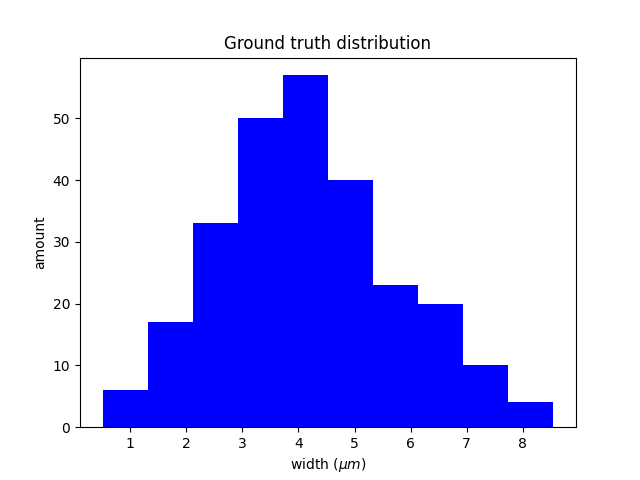

In [7]:
%matplotlib widget
width = list(width_dict.values())
plt.hist(width,color="blue")
plt.title("Ground truth distribution")
plt.xlabel("width ($\mathit{\mu m}$)")
plt.ylabel("amount")
plt.show()

In [8]:
df = pd.DataFrame(list(width_dict.items()),columns=["pos","width"]).set_index("pos")
df = df.sort_index()
df.to_excel("output.xlsx")

In [5]:
directory_groundtruths = os.path.join(storage_path)
directory_groundtruths

'/home/ipausers/lin/Desktop/data'

In [6]:
directory = directory_groundtruths +"/"
directory

'/home/ipausers/lin/Desktop/data/'

In [7]:
update_plate_info(directory)

analysed:   0%|          | 0/11 [00:00<?, ?it/s]

In [8]:
folder_df = get_current_folders(directory)
folder_df

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,unique_id,datetime
0,/home/ipausers/lin/Desktop/data/20221026_1013_...,452,32,'Carrot','C2','001P100N100C','Y','-',20221017,25,...,True,False,True,True,True,True,"26.10.2022, 10:13:",20221026_1013_Plate32,452_20221017,2022-10-26 10:13:00
1,/home/ipausers/lin/Desktop/data/20221116_0311_...,705,21,'Carrot','C2','001P100N100C','Y','-',20221014,25,...,True,False,True,True,True,True,"16.11.2022, 03:11:",20221116_0311_Plate21,705_20221014,2022-11-16 03:11:00
2,/home/ipausers/lin/Desktop/data/20230111_1248_...,493,11,'Carrot','Agg','001P100N100C','Y','-',20221206,25,...,True,False,True,True,True,True,"11.01.2023, 12:48:",20230111_1248_Plate24,493_20221206,2023-01-11 12:48:00
3,/home/ipausers/lin/Desktop/data/20230109_1409_...,521,2,'Carrot','C2','001P100N100C','Y','-',20230104,25,...,True,False,True,True,True,True,"09.01.2023, 14:09:",20230109_1409_Plate02_re,521_20230104,2023-01-09 14:09:00
4,/home/ipausers/lin/Desktop/data/20230111_1349_...,521,2,'Carrot','C2','001P100N100C','Y','-',20230104,25,...,True,False,True,True,True,True,"11.01.2023, 13:49:",20230111_1349_Plate02_re,521_20230104,2023-01-11 13:49:00


In [9]:
select = folder_df[folder_df["Plate"] == "705"]
select

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,unique_id,datetime
1,/home/ipausers/lin/Desktop/data/20221116_0311_...,705,21,'Carrot','C2','001P100N100C','Y','-',20221014,25,...,True,False,True,True,True,True,"16.11.2022, 03:11:",20221116_0311_Plate21,705_20221014,2022-11-16 03:11:00


In [10]:
%matplotlib widget
exp = Experiment(directory)
exp.load(select, suffix="")
exp.load_tile_information(0)
# plot_full_image_with_features(exp, 0, 
#                               downsizing=10,
#                               dilation=1,
#                               edges=get_all_edges(exp, 0),
#                               nodes=get_all_nodes(exp, 0))

/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2022-11-16 03:11:00


you select number 21 tile


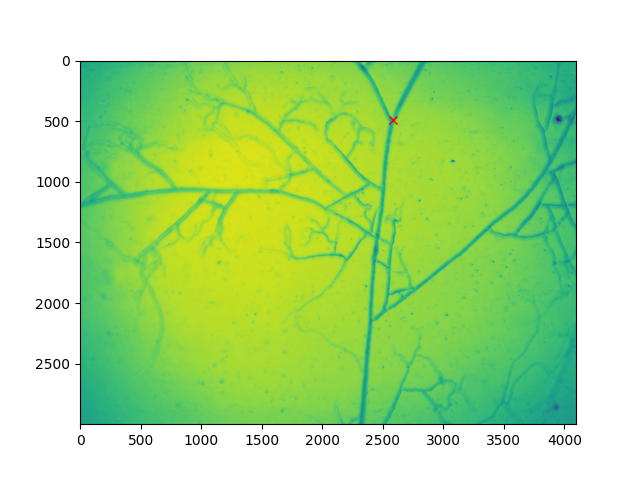

In [15]:
%matplotlib widget
def select_tile(row,column):
    row_count=-1
    row_list = [6,9,11,13,12,13,13,12,12]
    for i in range(row):
        row_count+=1
    if row_count == 0:
        print(f"you select number {column} tile")
        return column-1
    else:
        number = column + sum(row_list[:row_count])
    print(f"you select number {number+1} tile")
    return number
tile = select_tile(3,5)
# image_paths[t][tile_number]
# select_pic = [] 
show_image(exp.image_paths[0][tile])
plt.plot(2581, 489, marker="x", color="red")


In [12]:
import pandas as pd
select_exp = "/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/Experiment/Labelme/Fluorescence_ex_Kai-kai_Plate705.xlsx"
exp_df = pd.read_excel(select_exp,engine = "openpyxl",sheet_name="11.16",skiprows=1,index_col=0,header=0)
exp_df

,x,y,x_e,y_e,file name,Unnamed: 6,Unnamed: 7,Crossed date,2022-10-14 00:00:00
Name,,,,,,,,,
pos1,27780,19520,2473,610,focus01,focus02,focus03,Strain,C2
pos2,27460,22060,2455,776,pos02,NaN,NaN,Root,carrot
pos3,27480,23580,2444,878,pos03,NaN,NaN,plate position,21
pos4,27140,26220,2428,1046,pos04,NaN,NaN,Exp date,2022-11-16 00:00:00
pos5,27220,26960,2430,1046,pos05,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
pos60,3960,26000,913,1028,pos60,NaN,NaN,NaN,NaN
pos61,9720,24780,1290,941,pos61,NaN,NaN,NaN,NaN
pos62,11460,24600,1400,932,pos62,NaN,NaN,NaN,NaN


In [18]:
x_data = [i for i in exp_df.x]
y_data = [i for i in exp_df.y]
possdm1 = []
for i in range(len(x_data)):
    possdm1.append([x_data[i],y_data[i]])

In [19]:
x_data = [10*i for i in exp_df.x_e]
y_data = [10*i for i in exp_df.y_e]
possdm2 = []
for i in range(len(x_data)):
    possdm2.append([y_data[i],x_data[i]])
#Notice the x and y position should reverse.

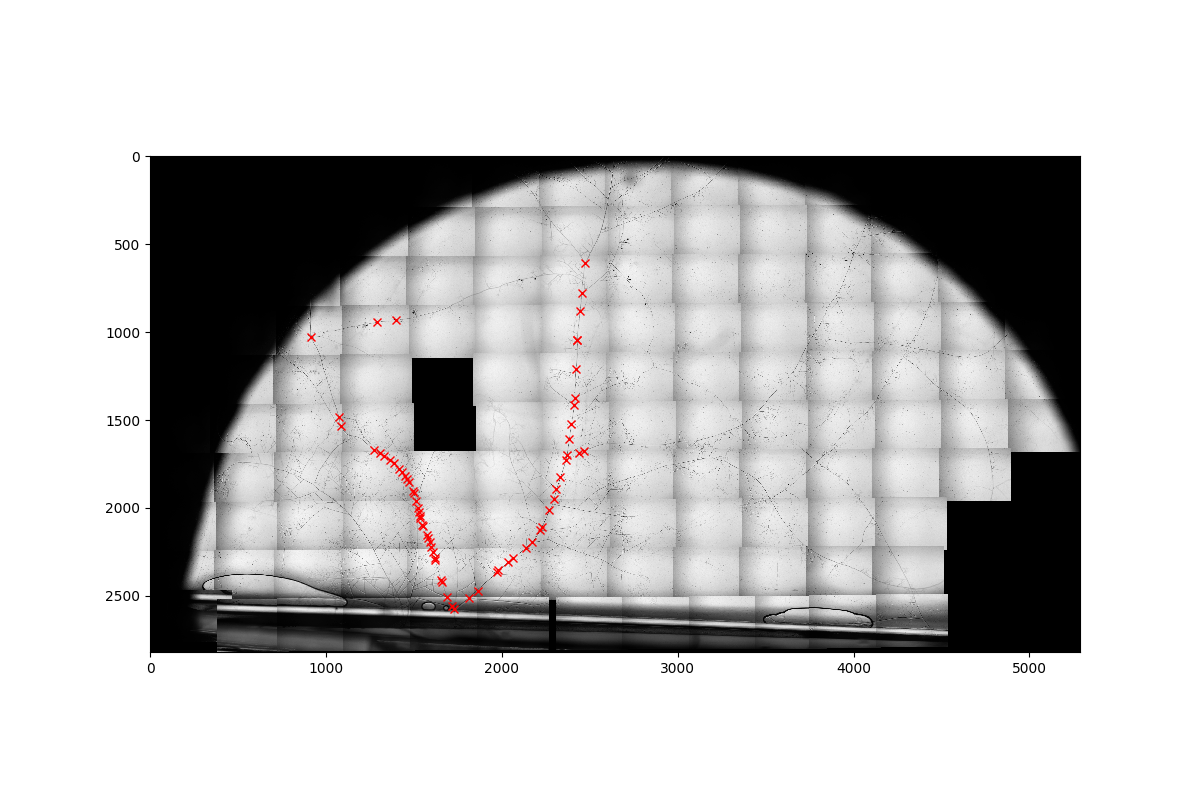

In [20]:
%matplotlib widget
plot_full_image_with_features(
    exp,
    t=0,
    downsizing=10,
    # region=[[0, 0], [26000, 52000]],
    points=possdm2,
)


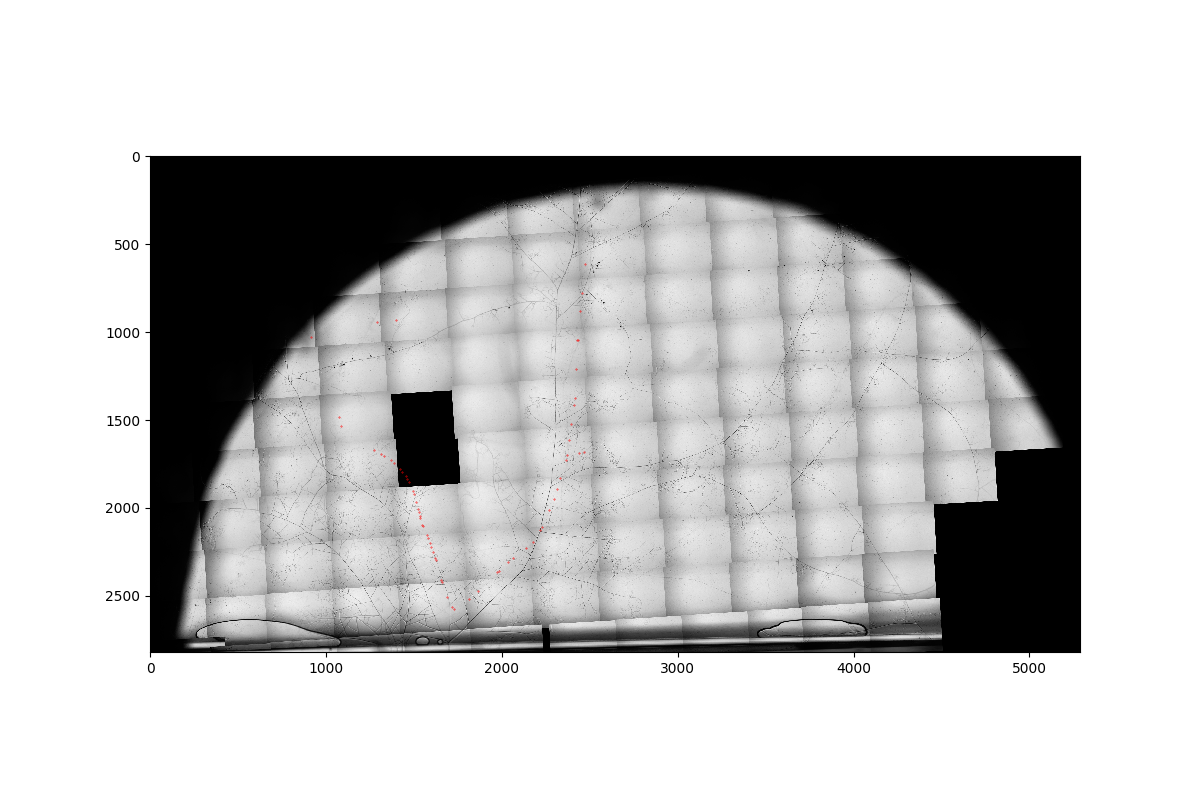

In [21]:
# Need to fix
%matplotlib widget
plot_full(
    exp,
    t=0,
    downsizing=10,
    # region=[[0, 0], [26000, 52000]],
    points=possdm2,
)

In [13]:
import pandas as pd
select_exp = "/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/Experiment/Labelme/Fluorescence_ex_Kai-kai_Plate705.xlsx"
exp_df_node= pd.read_excel(select_exp,engine = "openpyxl",sheet_name="experiment node",index_col=0)
exp_df_node

,position,top,R,R2,D,D2,D3,M,M2,M3,...,L3,L4,L5,LT,RT,LM,LM2,LD,MT,MD
pos3,410.0,NaN,NaN,NaN,"410, 556",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos4,598.0,"583, 598",NaN,NaN,"601, 662",NaN,NaN,"598, 601","598, 601",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos5,662.0,"601, 662","664, 657",NaN,"664, 793",NaN,NaN,"662, 664","662, 664",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos6,814.0,"664, 793","793, 827",NaN,"793, 814",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos7,1099.0,"1099, 983","1099, 1079",NaN,"1099, 1142",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pos60,681.0,"673, 503","673, 671",NaN,"681, 708",NaN,NaN,"681, 673","681, 673",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos61,NaN,NaN,"559, 521",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"559, 550",NaN,NaN,NaN,NaN,"559, 550","559, 550"
pos62,NaN,NaN,"559, 521",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos63,1641.0,NaN,"1641, 1611",NaN,"1641, 1689",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
label_pos = list(exp_df_node.columns[1:])
pos_dict = {}
for i in range(len(exp_df_node)):
    pic_pos = exp_df_node.index[i]
    node_dict = {}
    for index, value in enumerate(exp_df_node.iloc[i,1:]):
        if type(value) == str:
            node1, node2 = value.split(",")
            node_dict[label_pos[index]] = [int(node1),int(node2)]
    if len(node_dict) != 0:
        pos_dict[pic_pos] = node_dict

In [25]:
check = 0
for i in pos_dict.keys():
    check += len(pos_dict[i].values())
print(f"Total of the edge I am going to measure is {check} edges.")

Total of the edge I am going to measure is 195 edges.


In [16]:
# check the segment to prevent extract the wrong segment
pos = "pos60"
direction = "top"
pos_dict[pos]

{'top': [673, 503],
 'R': [673, 671],
 'D': [681, 708],
 'M': [681, 673],
 'M2': [681, 673],
 'L': [681, 628]}

In [17]:
edges = []
for edge in [pos_dict[pos][direction]]:
    edges.append(get_edge_from_node_labels(exp, 0, edge[0], edge[1]))
start_nodes = [edge.begin for edge in edges]
end_nodes = [edge.end for edge in edges]
nodes = [node for l in [start_nodes, end_nodes] for node in l ]
nodes,edges

([Node(503), Node(673)], [Edge(503,673)])

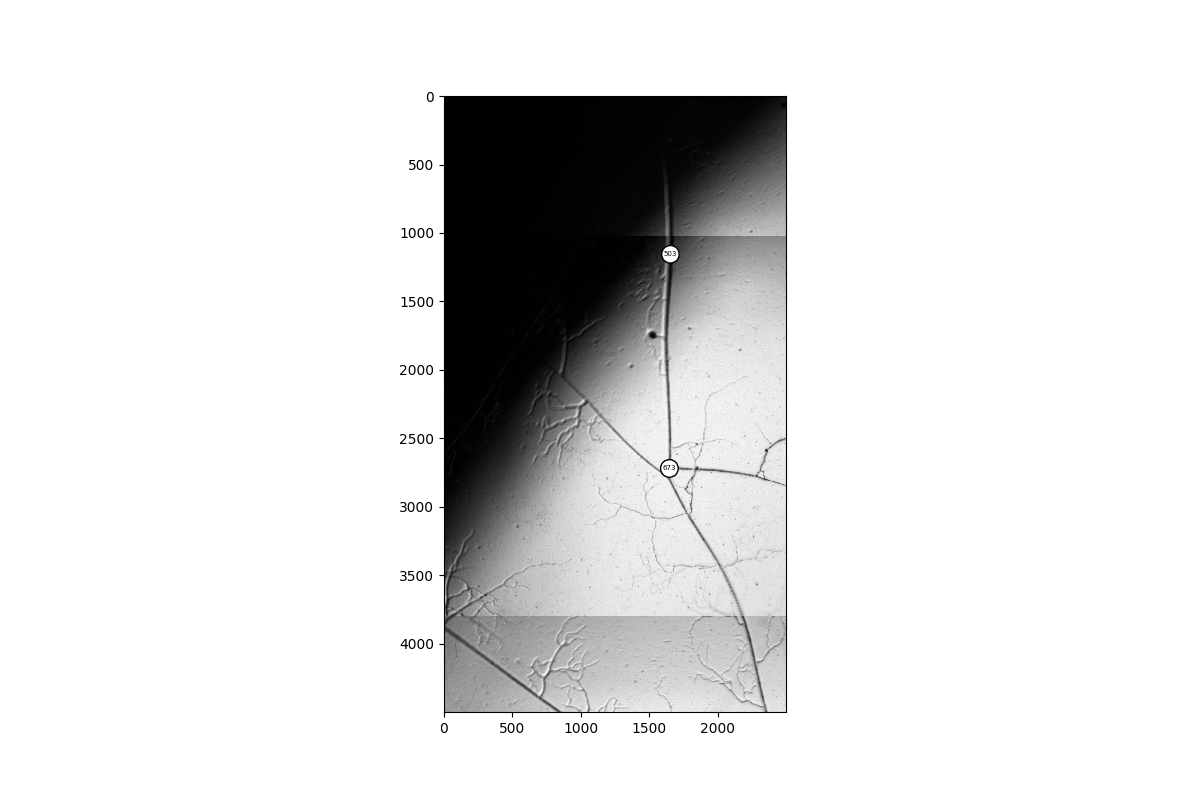

In [18]:
%matplotlib widget
plot_full_image_with_features(
    exp, 0, downsizing=1,dilation=1, nodes=nodes,region=[[7500,7500],[12000,10000]],)

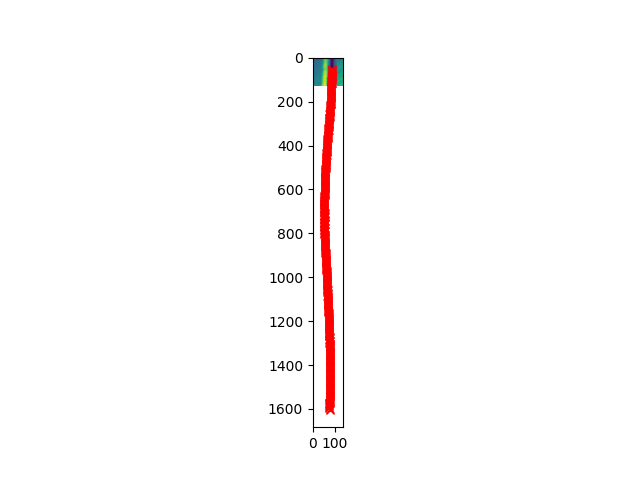

In [24]:
%matplotlib widget
edge = pos_dict[pos][direction]
edge = get_edge_from_node_labels(exp, 0, edge[0], edge[1])
f = lambda n: generate_index_along_sequence(n, resolution=4, offset=5)
f_profiles = lambda edge: extract_section_profiles_for_edge(
    exp, 0, edge, resolution=5, offset=5, step=1)
plot_edge_cropped(edge, 0, mode=3, f=f)

312


3

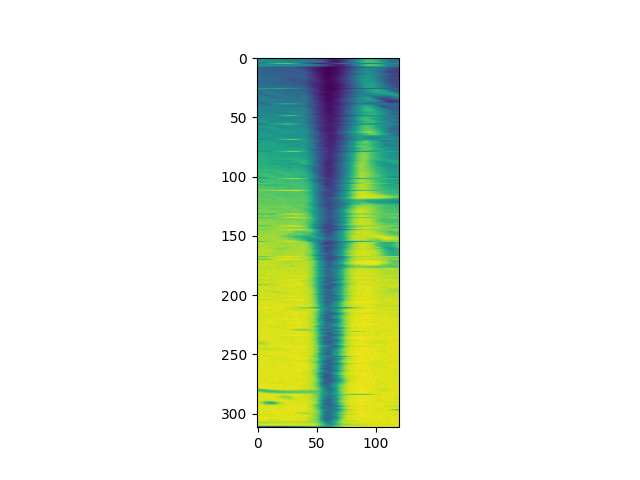

In [25]:
%matplotlib widget
slices, coords1, coords2 = f_profiles(edge)
plt.imshow(slices)
print(len(slices))
len(slices[0:3])

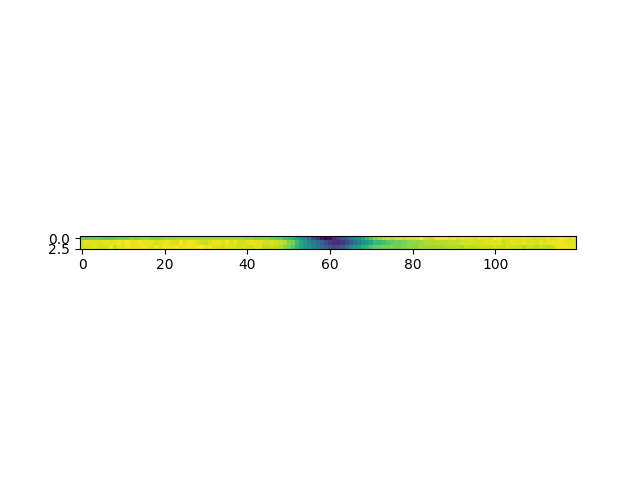

In [26]:
%matplotlib widget
# slices, coords1, coords2 = f_profiles(edge)
plt.imshow(slices[308:311])

In [21]:
sys.path.append("/home/ipausers/lin/Desktop/Kai/Graduation-Project/")
from models.model import*
latest = load_model(model_path,"BO_without_crop_best_model")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 1)            0         
                                                                 
 conv_1 (Conv1D)             (None, 101, 128)          2688      
                                                                 
 conv_2 (Conv1D)             (None, 91, 128)           180352    
                                                                 
 batch_normalization (BatchN  (None, 91, 128)          512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 91, 128)           0         
                                                                 
 flatten (Flatten)           (None, 11648)             0         
                                                        

In [44]:
np.where(latest.predict(slices)>17)

10/10 [==============================] - 0s 6ms/step


(array([60, 64]), array([0, 0]))

In [55]:
len(slices)

312

1/1 [==============================] - 0s 15ms/step
[[15.158731]
 [ 9.106083]
 [10.753293]]


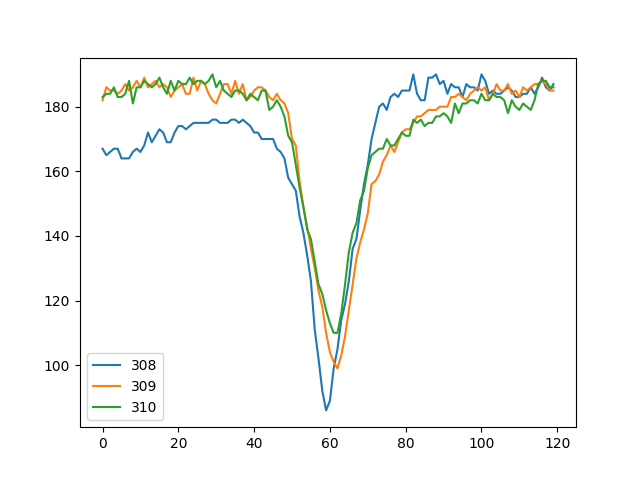

In [70]:
%matplotlib widget
np.where(latest.predict(slices)>17)
for i in range(308,311,1):
    plt.plot(slices[i:i+1][0],label = i)
plt.legend()
print(latest.predict(slices[308:311]))


In [78]:
latest.predict(slices)

10/10 [==============================] - 0s 6ms/step


array([[10.534331 ],
       [11.84541  ],
       [11.959644 ],
       [ 9.740304 ],
       [10.913239 ],
       [16.06198  ],
       [11.465343 ],
       [12.15546  ],
       [10.170387 ],
       [11.823292 ],
       [12.475984 ],
       [13.013697 ],
       [12.868523 ],
       [12.31386  ],
       [12.529476 ],
       [12.8881   ],
       [13.163353 ],
       [12.6613865],
       [12.014397 ],
       [11.278178 ],
       [11.446846 ],
       [12.083249 ],
       [13.292263 ],
       [12.925594 ],
       [13.5900135],
       [14.113854 ],
       [16.326902 ],
       [13.611954 ],
       [13.811501 ],
       [14.266173 ],
       [14.333236 ],
       [14.515104 ],
       [13.804714 ],
       [12.351881 ],
       [13.419898 ],
       [14.689864 ],
       [14.602013 ],
       [13.986325 ],
       [13.711108 ],
       [15.330101 ],
       [12.9419365],
       [14.4284115],
       [15.86374  ],
       [15.552292 ],
       [15.168841 ],
       [15.851838 ],
       [15.628254 ],
       [15.35

In [36]:
# ask the difference between plot_full and plot_full_image_with_features => plot_full_image_with already rotate
# ask camera_res keep 3.45 => the value gave from the company
# ask how to distinguish the different hyphae => define by yourself

In [29]:
import pandas as pd
select_exp = "/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/Experiment/Labelme/Fluorescence_ex_Kai-kai_Plate705.xlsx"
exp_df_slice = pd.read_excel(select_exp,engine = "openpyxl",sheet_name="experiment slice",index_col=0)
exp_df_slice

,position,top,R,R2,D,D2,D3,M,M2,M3,...,L3,L4,L5,LT,RT,LM,LM2,LD,MT,MD
pos3,410.0,NaN,NaN,NaN,[10:12],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos4,598.0,[23:25],NaN,NaN,[12:14],NaN,NaN,[1:3],[3:5],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos5,662.0,[92:95],[3:6],NaN,[213:217],NaN,NaN,[1:2],[2:3],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos6,814.0,[1:4],[4:6],NaN,[15:17],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos7,1099.0,[170:173],[3:5],NaN,[80:83],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pos60,681.0,[308:311],[1:4],NaN,[1:4],NaN,NaN,[0:3],[7:10],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos61,NaN,NaN,[0:3],NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,[9:12],NaN,NaN,NaN,NaN,[4:6],[2:4]
pos62,NaN,NaN,[178:180],NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos63,1641.0,NaN,[1:4],NaN,[1:4],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
labelme_df = pd.DataFrame.from_dict(width_dict,orient='index')
labelme_df = labelme_df.sort_index()
labelme_df.to_excel("labelme_raw.xlsx")

In [44]:
for index, value in labelme_df.iterrows():
    if len(index.split("_")) == 2:
        pos, direction = index.split("_")
        exp_df.at[pos.lower(),direction]=value[0]

In [72]:
select_exp = "/Users/kai/Downloads/graduation/Experiment/Labelme/Fluorescence_ex_Kai-kai_Plate705.xlsx"
label_df = pd.read_excel(select_exp,engine = "openpyxl",sheet_name="Labelme",index_col=0)
label_df

,position,top,R,R2,D,D2,D3,M,M2,M3,...,L3,L4,L5,LT,RT,LM,LM2,LD,MT,MD
pos3,410.0,5.466252,3.360181,NaN,5.978320,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos4,598.0,3.890178,NaN,NaN,4.738162,NaN,NaN,4.940548,4.970713,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos5,662.0,3.867490,2.815162,NaN,4.811456,NaN,NaN,4.886012,4.084507,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos6,814.0,5.118606,3.163404,NaN,4.191390,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos7,1099.0,4.057369,3.093466,NaN,5.192105,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pos60,681.0,8.546125,7.723462,NaN,6.794172,NaN,NaN,8.260645,7.327132,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos61,NaN,NaN,3.494587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.635567,NaN,NaN,NaN,NaN,2.809692,2.938713
pos62,NaN,3.247844,4.441835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos63,1641.0,NaN,4.753152,NaN,4.250022,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
# get the dict for slice
label_pos = list(exp_df_slice.columns[1:])
slices_dict = {}
for i in range(len(exp_df_slice)):
    pic_pos = exp_df_slice.index[i]
    slice_dict = {}
    for index, value in enumerate(exp_df_slice.iloc[i,1:]):
        if type(value) == str:
            first, second= value.replace("[","").replace("]","").split(":")
            slice_dict[label_pos[index]] = [int(first), int(second)]
    if len(slice_dict) != 0:
        slices_dict[pic_pos] = slice_dict

In [76]:
# get the dict for label
import math 
label_pos = list(label_df.columns[1:])
labels_dict = {}
for i in range(len(label_df)):
    pic_pos = label_df.index[i]
    label_dict = {}
    for index, value in enumerate(label_df.iloc[i,1:]):
        if not math.isnan(value):
            label_dict[label_pos[index]] = value
    if len(label_dict) != 0:
        labels_dict[pic_pos] = label_dict

In [77]:
# get the dict for node
label_pos = list(exp_df_node.columns[1:])
nodes_dict = {}
for i in range(len(exp_df_node)):
    pic_pos = exp_df_node.index[i]
    node_dict = {}
    for index, value in enumerate(exp_df_node.iloc[i,1:]):
        if type(value) == str:
            node1, node2 = value.split(",")
            node_dict[label_pos[index]] = [int(node1),int(node2)]
    if len(node_dict) != 0:
        nodes_dict[pic_pos] = node_dict

In [125]:
# create a dataset
f_profiles = lambda edge: extract_section_profiles_for_edge(exp, 0, edge, resolution=5, offset=5, step=1)
target_length = 120
collect_slice = []
collect_labels = []
for slice_key in slices_dict.keys():
    for slice_pos in slices_dict[slice_key].keys():
        edge = nodes_dict[slice_key][slice_pos]
        edge = get_edge_from_node_labels(exp, 0, edge[0], edge[1])
        slices, coords1, coords2 = f_profiles(edge)
        start, end  = slices_dict[slice_key][slice_pos]
        collect_slice.extend(slices[start:end])
        collect_labels.extend([labels_dict[slice_key][slice_pos]]*len(slices[start:end]))

In [156]:
slice_array = np.array(collect_slice)
label_array = np.array(collect_labels)
print(f"Slice array: {slice_array.shape} Label array: {label_array.shape}")

Slice array: (542, 120) Label array: (542,)


In [158]:
os.mkdir(os.path.join(storage_path, "vary_width"))
cv2.imwrite(os.path.join(storage_path, "vary_width","slices.png"), slice_array)
with open(os.path.join(storage_path, "vary_width","labels.npy"), "wb") as f:
    np.save(f, label_array)
with open(os.path.join(storage_path, "vary_width","info.txt"), "w") as f:
    f.write(f"Slice array: {slice_array.shape} Label array: {label_array.shape}")
    f.write('\nPlate number 705\nStrain: C2\nCrossdate: 10/14\nPrince position: 21\nPRINCE FULL DATA: 20221116_0311_Plate21')